# Codeathon 1

**Nikki Aaron: na5zn**

**Luke Moles: lmm8fb**

**Annie Williams: maw3as**

In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans

## Examine Data

In [72]:
# from google.colab import files
# uploaded = files.upload()

Saving housing.csv to housing (1).csv


In [527]:
# read in data
housing = pd.read_table('housing.csv', header=None)
housing = pd.DataFrame(housing[0].str.split().to_list(),
                       columns=['CRIM','ZN','INDUS','CHAS','NOX',
                                'RM','AGE','DIS','RAD','TAX',
                                'PTRATIO','MEDV','B','LSTAT'])
housing = housing.astype('float64')
housing.CHAS = pd.Categorical(housing.CHAS)
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,MEDV,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


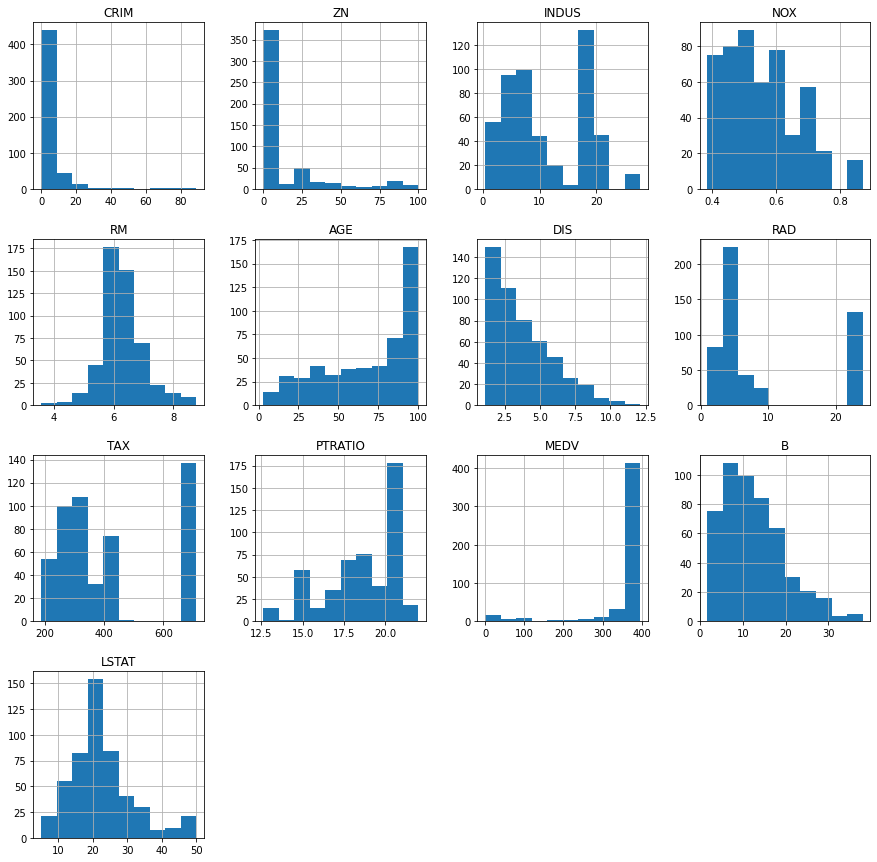

In [524]:
# exxamine the distributions
housing.hist(figsize=(15,15));

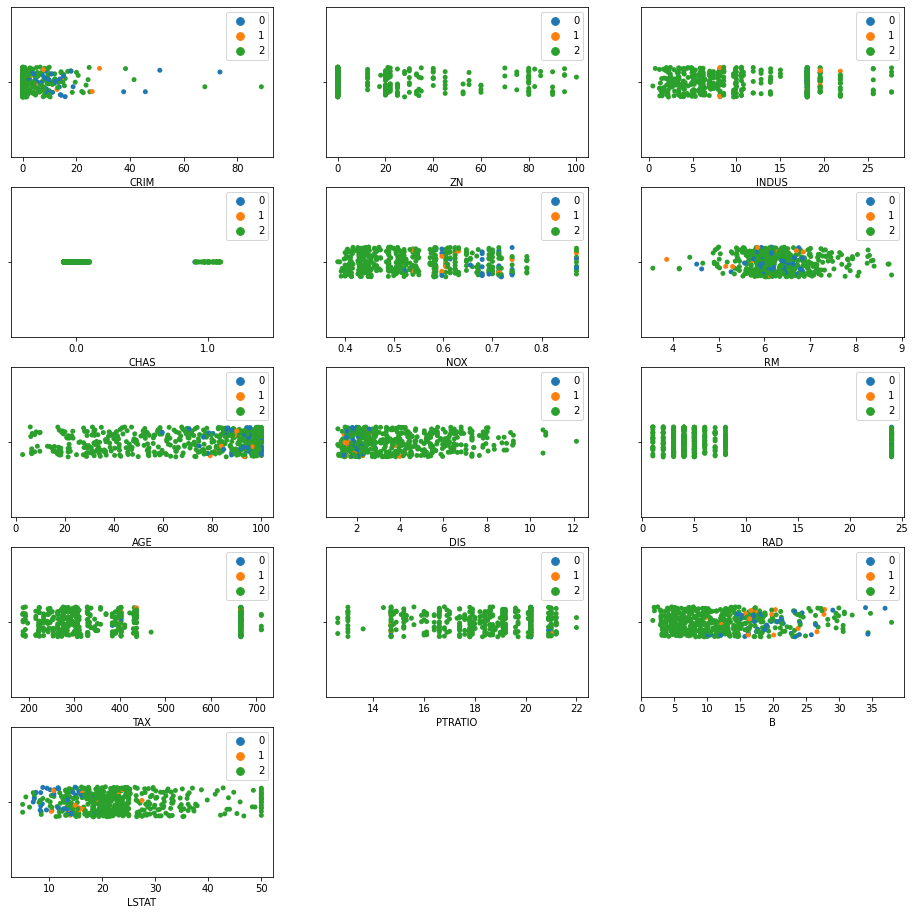

In [528]:
features = housing.copy()
medv_bins = pd.cut(features.MEDV, bins=[0,110,275,500], labels=[0,1,2])
features['medv_bins'] = medv_bins
features.head()

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(16, 16))

cols = features.drop(['MEDV','medv_bins'], axis=1).columns
for k,col in enumerate(cols):
  i = k // 3
  j = k % 3
  sns.stripplot(ax=axs[i,j], x=features[col], y=['']*len(features), hue=features.medv_bins)
  plt.setp(axs[i,j].get_legend().get_texts(), fontsize='8')
  axs[i,j].legend().set_title('')

fig.delaxes(axs[4,1])
fig.delaxes(axs[4,2])

## Process Data

Next we will perform some feature engineering. First we try clustering by all predictor features.

In [77]:
# run through various values of K
kmax = 9
results = np.vstack((list(range(1, kmax)), np.zeros(kmax-1)))
data = housing.drop('MEDV', axis=1).values
for k in range(1, kmax):
  clust = KMeans(n_clusters=k)
  clust.fit(data)
  wss = 0
  for i,item in enumerate(data):
    wss += np.linalg.norm(item - clust.cluster_centers_[clust.labels_[i]])
  results[1, k-1] = wss

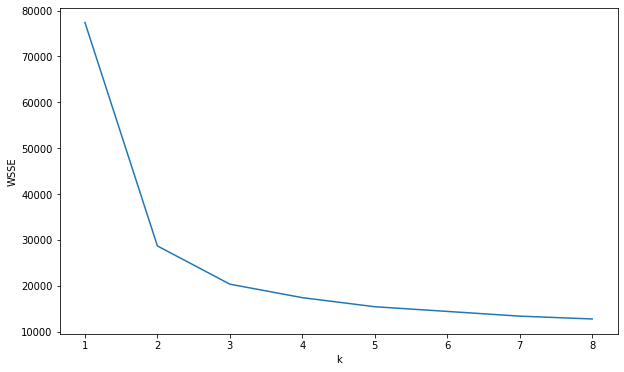

In [78]:
# Plot results of clustering
fig = plt.figure(figsize=(10,6))
plt.plot(results[0], results[1])
plt.xlabel('k')
plt.ylabel('WSSE');

In [130]:
# we will use k=2 clusters
clusters = KMeans(n_clusters=2).fit(data)

Now we construct the final dataset with engineered features.

In [529]:
features = housing.copy()

# add cluster feature
features['CLUSTER'] = clusters.labels_

# bin TAX
tax_bins = pd.cut(features.TAX, bins=[0,550,900], labels=[0,1])
features['tax_bins'] = tax_bins

# bin DIS
dis_bins = pd.cut(features.DIS, bins=[0,3,100], labels=[0,1])
features['dis_bins'] = dis_bins

# bin B
b_bins = pd.cut(features.B, bins=[0,17,100], labels=[0,1])
features['b_bins'] = b_bins

# bin LSTAT
lstat_bins = pd.cut(features.LSTAT, bins=[0,25,40, 100], labels=[0,1,2])
lstat_bins = pd.get_dummies(lstat_bins, prefix='lstat_')
features = pd.concat([features,lstat_bins], axis=1)

# bin CRIM
crim_bins = pd.cut(features.CRIM, bins=[0,10,25,100], labels=[0,1,2])
crim_bins = pd.get_dummies(crim_bins, prefix='crim_')
features = pd.concat([features,crim_bins], axis=1)

# separate target feature
medv = features.pop('MEDV')
features.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CLUSTER,tax_bins,dis_bins,b_bins,lstat__0,lstat__1,lstat__2,crim__0,crim__1,crim__2
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0,1,0,1,0,1,0,0,1,0,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6,1,0,1,0,1,0,0,1,0,0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7,1,0,1,0,0,1,0,1,0,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4,1,0,1,0,0,1,0,1,0,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2,1,0,1,0,0,1,0,1,0,0


In [530]:
# build dataset in TF
dataset = tf.data.Dataset.from_tensor_slices((features.values, medv.values))

# split into train and test
# batch size 64
n_data = len(dataset)
n_train = int(0.9*n_data)
batch_size = 64

tf.random.set_seed(49)
dataset_shuff = dataset.shuffle(buffer_size=n_data, reshuffle_each_iteration=False)
train_data = dataset_shuff.take(n_train).batch(batch_size)
test_data = dataset_shuff.skip(n_train).batch(batch_size)

In [532]:
# verify shape and split
for feat, lab in test_data:
  print(lab)

tf.Tensor(
[396.21 396.9  396.9  376.57  96.73 395.5  393.49 394.33 391.25 392.18
 354.7  272.21 396.9  353.89 364.31  70.8  390.3  396.9  393.77 351.85
 396.9  393.36 388.37 390.49 394.74 395.63 394.43 396.9  394.08 396.9
 390.95 369.3  395.24 396.9  387.38 380.02 372.49 383.61 378.35 396.9
 347.88 393.23 394.51 285.83 389.15 395.21 395.56 350.65 391.93 396.9
 396.9 ], shape=(51,), dtype=float64)


## Build Model

We will build a model with normalization and five hidden layers using ELU activation.

In [542]:
shape_in = len(features.columns)

keras.backend.clear_session()

inputs = keras.Input(shape=(shape_in))
layer_norm = keras.layers.LayerNormalization()(inputs)
dense_1 = keras.layers.Dense(256, activation='elu')(layer_norm)
dense_2 = keras.layers.Dense(128, activation='elu')(dense_1)
dense_3 = keras.layers.Dense(64, activation='elu')(dense_2)
dense_4 = keras.layers.Dense(32, activation='elu')(dense_3)
dense_5 = keras.layers.Dense(16, activation='elu')(dense_4)
outputs = keras.layers.Dense(1, activation='linear')(dense_5)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
layer_normalization (LayerNo (None, 23)                46        
_________________________________________________________________
dense (Dense)                (None, 256)               6144      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528   

Now we compile using RMSprop with momentum as our optimizer.

In [543]:
model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=0.001, momentum=0.2),
    loss=tf.losses.MeanSquaredError(),
    metrics=tf.metrics.RootMeanSquaredError()
)

In [544]:
# use early stopping to save ebst result
callback = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5)
history = model.fit(train_data, epochs=50, 
                    validation_data=test_data, 
                    callbacks=callback)

Epoch 1/50
8/8 [==============================] - 1s 29ms/step - loss: 134799.3490 - root_mean_squared_error: 367.1419 - val_loss: 135516.0781 - val_root_mean_squared_error: 368.1251
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 128302.8099 - root_mean_squared_error: 358.1766 - val_loss: 117483.6875 - val_root_mean_squared_error: 342.7589
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 102457.6875 - root_mean_squared_error: 319.8643 - val_loss: 55114.7930 - val_root_mean_squared_error: 234.7654
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 39720.4991 - root_mean_squared_error: 198.1888 - val_loss: 6279.4077 - val_root_mean_squared_error: 79.2427
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 9029.2626 - root_mean_squared_error: 94.8647 - val_loss: 4197.7134 - val_root_mean_squared_error: 64.7898
Epoch 6/50
8/8 [==============================] - 0s 8ms/step - loss: 8304.3283 - root_mean_squared_

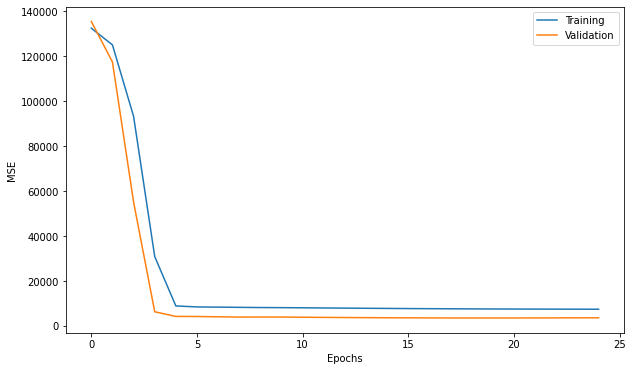

In [546]:
x = history.epoch
y_train = history.history['loss']
y_test = history.history['val_loss']

fig = plt.figure(figsize=(10,6))
plt.plot(x, y_train, label='Training')
plt.plot(x, y_test, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend();

In [547]:
model.evaluate(test_data)

1/1 [==============================] - 0s 17ms/step - loss: 3512.8284 - root_mean_squared_error: 59.2691


[3512.828369140625, 59.26911926269531]

The results show RMSE on the test set of 59.2691